In [80]:
# Importing PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [81]:
# Function to return the train and test data loaders for the CIFAR-10 dataset
def get_cifar10_data_loaders(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Task 1: Loading the datasets and defining the dataloaders
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

In [82]:
# Creating the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [83]:
# Creating the Backbone
class Backbone(nn.Module):
    def __init__(self, num_blocks, K):
        super(Backbone, self).__init__()
        self.num_blocks = num_blocks
        self.K = K
        self.blocks = nn.ModuleList()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        for _ in range(num_blocks):
            self.blocks.append(ResidualBlock(self.in_channels, 64))
            self.blocks.append(ResidualBlock(64, 64))

        self.linear = nn.Linear(64, K)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        for n in range(self.num_blocks * 2):
            x = self.blocks[n](x)

        spatial_avg = self.avgpool(x).view(x.size(0), -1)
        a = F.softmax(self.linear(spatial_avg), dim=1)

        return x, a

In [84]:
# Creating the Classifier
class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.avgpool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x

In [85]:
# Task 2: Creating the Model
class Model(nn.Module):
    def __init__(self, num_blocks, K, num_classes=10):
        super(Model, self).__init__()
        self.backbone = Backbone(num_blocks, K)
        self.classifier = Classifier(num_classes)

    def forward(self, x):
        x, a = self.backbone(x)
        x = self.classifier(x)
        return x

In [86]:
from torch.optim.lr_scheduler import StepLR

# Hyperparameters
num_blocks = 3
K = 10
num_classes = 10
learning_rate = 0.001
batch_size = 100
num_epochs = 30
step_size = 30
gamma = 0.1

# Loading the data
trainloader, testloader = get_cifar10_data_loaders(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [87]:
# Task 3: Creating the loss, optimizer, and scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model(num_blocks, K, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [88]:
# Task 4: Training Script
def get_accuracy(output, labels):
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    return 100 * correct / labels.size(0)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Updating running loss and accuracy
        running_loss += loss.item()
        running_accuracy += get_accuracy(outputs, labels)

        # Print batch statistics
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(trainloader)}
        , Train Loss: {loss.item():.4f}, Train Accuracy: {get_accuracy(outputs, labels):.2f}%")

    # Updating learning rate scheduler
    scheduler.step()

    # Evaluating the model on the test set
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_accuracy += get_accuracy(outputs, labels)

    # Calculating average loss and accuracy for the epoch
    avg_train_loss = running_loss / len(trainloader)
    avg_train_accuracy = running_accuracy / len(trainloader)
    avg_test_loss = test_loss / len(testloader)
    avg_test_accuracy = test_accuracy / len(testloader)

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_accuracy)

    # Printing the model loss and accuracies for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}
    , Train Accuracy: {avg_train_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}
    , Test Accuracy: {avg_test_accuracy:.2f}%")

# Task 5: Obtaining the final model accuracy on the CIFAR-10 Validation Set
print(f"Finished training with a validation accuracy of: {avg_test_accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Epoch 21/30, Batch 12/500, Train Loss: 0.3479, Train Accuracy: 87.00%
Epoch 21/30, Batch 13/500, Train Loss: 0.1621, Train Accuracy: 94.00%
Epoch 21/30, Batch 14/500, Train Loss: 0.3840, Train Accuracy: 85.00%
Epoch 21/30, Batch 15/500, Train Loss: 0.2165, Train Accuracy: 92.00%
Epoch 21/30, Batch 16/500, Train Loss: 0.2894, Train Accuracy: 88.00%
Epoch 21/30, Batch 17/500, Train Loss: 0.2552, Train Accuracy: 90.00%
Epoch 21/30, Batch 18/500, Train Loss: 0.4302, Train Accuracy: 85.00%
Epoch 21/30, Batch 19/500, Train Loss: 0.4423, Train Accuracy: 88.00%
Epoch 21/30, Batch 20/500, Train Loss: 0.2131, Train Accuracy: 95.00%
Epoch 21/30, Batch 21/500, Train Loss: 0.2006, Train Accuracy: 94.00%
Epoch 21/30, Batch 22/500, Train Loss: 0.3457, Train Accuracy: 86.00%
Epoch 21/30, Batch 23/500, Train Loss: 0.3531, Train Accuracy: 89.00%
Epoch 21/30, Batch 24/500, Train Loss: 0.3938, Train Accuracy: 89.00%
Epoch 21/30, Batch 25/500, Train Loss: 

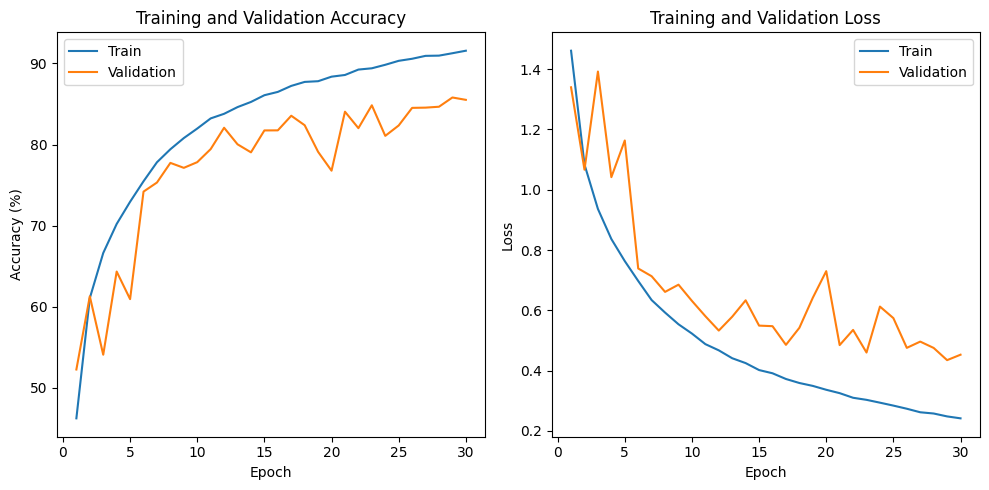

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Validation Accuracy")

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train")
plt.plot(range(1, num_epochs + 1), test_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()
